# Text Classification and Topic Modelling Project


In [1]:
import torch
import pandas as pd 
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext import data
from torchtext import datasets
from torchtext.data import TabularDataset

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import numpy as np

## Part 1:  Text Classification



### 1.Problem definition

The three classes are InfoTheory, CompVis and Math. These can occur in any combination, so an article could be all three at once, two, one or none.

Build three text classifiers that predict these three classes only using the Abstract field. 

You should present two different text classifiers for the three Boolean prediction tasks, and exactly one should be a neural network. That is, you develop three classifiers of the same kind of neural network that predict InfoTheory,
CompVis and Math, and another three classifiers of the same kind (which cannot be neural networks) that predict the three Booleans again.Each set of three classifiers can (and probably should) share processing and data structures. The
first set is to be called "Neural Network Method" and the second set called "Machine Learning
Method".

They should be clearly marked in the notebook file. Each set should be evaluated and a
full confusion matrix printed, giving 6 confusion matrices in all (2 methods by 3 Booleans).

You may **include 1-2 early experiments in your notebook for each of the two methods describing
preliminary methods you tested. This would be used for the purposes of discussing your final
method and the advantages of it.**

### Part 1: Neural Network Method



   **Summarization**: In this part, I did the data preparation and trained the data by using 3 different models: simple RNN, LSTM, FastText. However, since the essence of LSTM, the trainning time is significantly long so I stopped the trainning execution and focused on training RNN and FastText with different combinations of hyperparameters. For example, using trainned vector such as glove.6B.100d, glove.6B.30d, embedding dimension = 100 or 200, however the training and validation loss of RNN and FastText with the different combination is quite similar. Then,I moved to employ different type of Optimizers.

    Training and validation loss of simple RNN maintain around 80 - 82% (for both SGD and Adam)
    Training and validation loss of FastText is remarkbly high after 1 or 2 epoch( over 90% - when training with Adam) - so I reduce learning rate and use less epoch to avoid overfit
    
   **Conclusion**: FastText seems powerful for this classification task, more efficient compare to LSTM and RNN (similar training time to RNN but with lower loss).

The details is written down below to show the points

#### Data Preparation


In [7]:
#read datafile 
df_train = pd.read_csv("axcs_train.csv") 
df_test = pd.read_csv("axcs_test.csv") 


In [3]:
#checking missing values of train data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54731 entries, 0 to 54730
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          54731 non-null  object
 1   URL         54731 non-null  object
 2   Date        54731 non-null  object
 3   Title       54731 non-null  object
 4   InfoTheory  54731 non-null  int64 
 5   CompVis     54731 non-null  int64 
 6   Math        54731 non-null  int64 
 7   Abstract    54731 non-null  object
dtypes: int64(3), object(5)
memory usage: 3.3+ MB


In [4]:
#checking missing values of train data
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19679 entries, 0 to 19678
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          19679 non-null  object 
 1   URL         19679 non-null  object 
 2   Date        19679 non-null  object 
 3   Title       19679 non-null  object 
 4   InfoTheory  19678 non-null  float64
 5   CompVis     19678 non-null  float64
 6   Math        19678 non-null  float64
 7   Abstract    19678 non-null  object 
dtypes: float64(3), object(5)
memory usage: 1.2+ MB


**Comment:** It seems we have a row with missing value in test data

In [101]:
#print out the missing row
print(df_test[df_test["InfoTheory"].isnull()])

                 ID                       URL        Date  \
19619  no-160308961  arxiv.org/abs/1603.08961  2016-03-29   

                                                   Title  InfoTheory  CompVis  \
19619  Betting and Belief: Prediction Markets and Att...         NaN      NaN   

       Math Abstract  
19619   NaN      NaN  


**Comment:** Since our data is abundant so we could remove this defect

In [8]:
#drop the row contains missing values and save to the cleaned test data file
cleaned_df_test = df_test.drop(19619)
cleaned_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19678 entries, 0 to 19678
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          19678 non-null  object 
 1   URL         19678 non-null  object 
 2   Date        19678 non-null  object 
 3   Title       19678 non-null  object 
 4   InfoTheory  19678 non-null  float64
 5   CompVis     19678 non-null  float64
 6   Math        19678 non-null  float64
 7   Abstract    19678 non-null  object 
dtypes: float64(3), object(5)
memory usage: 1.4+ MB


In [9]:
#save cleaned data to a csv file 
convert_dict = {'InfoTheory': int, 
                'CompVis': int,
                'Math': int,
               } 

cleaned_df_test = cleaned_df_test.astype(convert_dict) 
cleaned_df_test.to_csv("clean_axcs_test.csv",index = False, header=True, encoding='utf8')


In [27]:
#create the function to generate the bigrams for FastText model 
def generate_bigrams(x):
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    return x

In [104]:
SEED = 75
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#set up the tokenization
def set_up_TEXT_and_datafields(preprocessing):
    TEXT = data.Field(sequential=True, tokenize = 'spacy', lower=True, include_lengths = True, preprocessing = preprocessing)
    
    #set up the datafields for each subject
    infoTheory_datafields = [("ID", None), 
                 ("URL", None),
                 ("Date", None),
                 ("Title", None),
                 ("label", LABEL),
                 ('CompVis',None),
                 ('Math',None),
                 ("Abstract", TEXT)]
    
    compvis_datafields = [("ID", None),
                ("URL", None),
                ("Date", None),
                ("Title", None),
                ("InfoTheory", None),
                ('label', LABEL),
                ('Math',None),
                ("Abstract", TEXT)]

    math_datafields = [("ID", None),
                ("URL", None),
                ("Date", None),
                ("Title", None),
                ("InfoTheory", None),
                ('CompVis',None),
                ('label', LABEL),
                ("Abstract", TEXT)]
    
    return TEXT, infoTheory_datafields, compvis_datafields, math_datafields

#Tokenize but do not calculate the n-grams of an input sentence
TEXT_RNN, infoTheory_datafields_RNN, compvis_datafields_RNN, math_datafields_RNN = set_up_TEXT_and_datafields(None) 

#Tokenize and calculate the n-grams of the input sentence
TEXT_FT, infoTheory_datafields_FT, compvis_datafields_FT, math_datafields_FT = set_up_TEXT_and_datafields(generate_bigrams)

LABEL = data.LabelField(dtype = torch.float, use_vocab=False, preprocessing=int)

#Choose the setting for device, using GPU for trainning if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [108]:
#Build the pre processing function

def pre_processing(datafields,TEXT, vocabSize):
    """the purpose of this function is combining many pre-processing steps in to
    one so we could apply for different selection of datafields, TEXT and vocabulary size"""
    
    #Read and split the data into train, validation, test sets
    
    train_data, test_data = TabularDataset.splits(path='',
    train='axcs_train.csv',
    test='clean_axcs_test.csv', format='csv',skip_header=True,
    fields=datafields)
    
    train_data, valid_data = train_data.split(random_state = random.seed(SEED))
    
    print(f'Number of training examples: {len(train_data)}')
    print(f'Number of validation examples: {len(valid_data)}')
    print(f'Number of testing examples: {len(test_data)}')
    print("-------------------------------------------------")
       
    #Build vocabulary 
    
    MAX_VOCAB_SIZE = vocabSize
    
    #text depend on type of TEXT being chose
    TEXT.build_vocab(train_data, 
                 max_size=MAX_VOCAB_SIZE,
                 vectors='glove.6B.100d', #try to use without vector, with glove + with word2vec
                 unk_init=torch.Tensor.normal_)
    
    #label depend on type of TEXT being chose
    LABEL.build_vocab(train_data)

    BATCH_SIZE = 64 
    
    #BucketIterator will attempt to batch together samples with similar lengths to minimize the amount of padding needed.
    train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
        (train_data, valid_data, test_data), 
        batch_size = BATCH_SIZE,
        device = device,
        sort_key = lambda x: len(x.Abstract),
        sort_within_batch = True)   

    return TEXT, LABEL, train_iterator, valid_iterator, test_iterator




**Note:** For the convenient of experiment, we only create the iterator for infoTheory subject

In [109]:
 #Creating the iterators for infoTheory subject
textRNN_infoTheory,labelRNN_infoTheory, train_iterRNN_info, valid_iterRNN_info, test_iterRNN_info = pre_processing(infoTheory_datafields_RNN,TEXT_RNN, 10000)


Number of training examples: 38312
Number of validation examples: 16419
Number of testing examples: 19678
-------------------------------------------------


**Note:** Since I did the experiment so in this step , we could set up the iterator for different subjects and use them later for training  FastText

In [110]:
#build the iterator for different subjects for FastText model
textFT_infoTheory, labelFT_info, train_iterFT_info, valid_iterFT_info, test_iterFT_info = pre_processing(infoTheory_datafields_FT,TEXT_FT,10000)
textFT_comp, labelFT_comp, train_iterFT_comp, valid_iterFT_comp, test_iterFT_comp = pre_processing(compvis_datafields_FT,TEXT_FT,10000)
textFT_math, labelFT_math, train_iterFT_math, valid_iterFT_math, test_iterFT_math = pre_processing(math_datafields_FT,TEXT_FT,10000)


Number of training examples: 38312
Number of validation examples: 16419
Number of testing examples: 19678
-------------------------------------------------
Number of training examples: 38312
Number of validation examples: 16419
Number of testing examples: 19678
-------------------------------------------------
Number of training examples: 38312
Number of validation examples: 16419
Number of testing examples: 19678
-------------------------------------------------


### Build the Model

In order to comparing the performance of the deep neuro network, we will employ basic RNN module and, advance LSTM model ( multiple layers of LSTM, reading the text in bidirectional, adding drop out ratio to reduce overfit) and FastText.


#### Set up the model structure

In [113]:
#basic RNN

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))



In [114]:
#Advance RNN - LSTM model(multiple layers of LSTM, reading the text in bidirectional, adding drop out ratio to reduce overfit)

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)


In [44]:
#build model FastText

class FastText(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
                
        #embedded = [sent len, batch size, emb dim]
        
        embedded = embedded.permute(1, 0, 2)
        
        #embedded = [batch size, sent len, emb dim]
        
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 
        
        #pooled = [batch size, embedding_dim]
                
        return self.fc(pooled)

#### Define the hyperparameter and instantiate the models

In [117]:
#define hyperparameters
#By using the same vocabulary size of input diment of RNN and FastText, we only 
# need to set up one input_dimension hyperparameter

INPUT_DIM = len(TEXT_RNN.vocab)  
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = TEXT_FT.vocab.stoi[TEXT_FT.pad_token] 

#instantiate the model

model_RNN = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model_LSTM = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS,
            BIDIRECTIONAL, DROPOUT, PAD_IDX)
model_FT = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)

#set up function to count the number of parameter

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model_RNN):,} trainable parameters')

print(f'The model has {count_parameters(model_LSTM):,} trainable parameters')

print(f'The model has {count_parameters(model_FT):,} trainable parameters')


The model has 1,029,769 trainable parameters
The model has 1,631,241 trainable parameters
The model has 1,000,301 trainable parameters


In [118]:
#copy pre-trained vectors to embedding layer of FastText

pretrained_embeddings = TEXT_FT.vocab.vectors

model_FT.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.2682, -1.0412, -0.0179,  ..., -1.0379,  1.3348, -0.7338],
        [-2.0590, -0.2489,  1.2510,  ..., -0.6897, -0.8276, -0.1047],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 1.0728,  1.3104,  0.1435,  ...,  0.8074, -0.2621, -0.6728],
        [-0.3706, -0.3150,  0.4277,  ..., -0.5446,  0.1919, -0.2717],
        [ 0.3087, -0.0571, -1.2480,  ..., -2.1347,  2.1336, -1.0416]])

In [119]:
#zero the initial weights of unknown and padding tokens.

UNK_IDX = TEXT_FT.vocab.stoi[TEXT_FT.unk_token]

model_FT.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model_FT.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

### Train the Model

We will use 2 different types of optimizer to train the model and compare the result

In [120]:
#instantiate the optimizer and loss function for RNN
optimizer_SGD_RNN = optim.SGD(model_RNN.parameters(), lr=1e-3)
optimizer_Adam_RNN = optim.Adam(model_RNN.parameters(),lr=0.01)

#instantiate the optimizer and loss function for LSTM
optimizer_SGD_LSTM = optim.SGD(model_LSTM.parameters(), lr=1e-3)
optimizer_Adam_LSTM = optim.Adam(model_LSTM.parameters(),lr=0.01)

#instantiate the optimizer and loss function for FastText
optimizer_SGD_FT = optim.SGD(model_FT.parameters(), lr=1e-3)
optimizer_Adam_FT = optim.Adam(model_FT.parameters(),lr=0.001) #learning rate has been reduced 
                                                               # from 0.01 as other models to 0.001 to reduce overfit

criterion = nn.BCEWithLogitsLoss()

#place the model and the criterion on the GPU
model_RNN = model_RNN.to(device)
model_LSTM = model_LSTM.to(device)
model_FT = model_FT.to(device)

criterion = criterion.to(device)

In [121]:
# implement function to calculate accuracy
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [122]:
#buiding train + evaluate functions
# since the way LSTM use to train the model a bit different compared to RNN and FastText 
# so I separated to a diffent couple of train and validation

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.Abstract[0]).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.Abstract[0]).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def train_LSTM(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.Abstract
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate_LSTM(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.Abstract
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [123]:
# implement function to count duration for each epoch

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

##### Training the base model RNN(with SGD and Adam optimizer)

In [124]:
#training the RNN model + SGD optimizer
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_RNN, train_iterRNN_info, optimizer_SGD_RNN, criterion)
    valid_loss, valid_acc = evaluate(model_RNN, valid_iterRNN_info, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_RNN.state_dict(), 'RNN_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epochs Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    

Epoch: 01 | Epochs Time: 1m 42s
	Train Loss: 0.553 | Train Acc: 74.51%
	 Val. Loss: 0.512 |  Val. Acc: 80.51%
Epoch: 02 | Epochs Time: 1m 38s
	Train Loss: 0.497 | Train Acc: 80.53%
	 Val. Loss: 0.495 |  Val. Acc: 80.56%
Epoch: 03 | Epochs Time: 1m 38s
	Train Loss: 0.493 | Train Acc: 80.51%
	 Val. Loss: 0.493 |  Val. Acc: 80.57%
Epoch: 04 | Epochs Time: 1m 40s
	Train Loss: 0.493 | Train Acc: 80.56%
	 Val. Loss: 0.492 |  Val. Acc: 80.58%
Epoch: 05 | Epochs Time: 1m 40s
	Train Loss: 0.492 | Train Acc: 80.56%
	 Val. Loss: 0.492 |  Val. Acc: 80.58%


In [125]:
#training the RNN model + Adam optimizer
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_RNN, train_iterRNN_info, optimizer_Adam_RNN, criterion)
    valid_loss, valid_acc = evaluate(model_RNN, valid_iterRNN_info, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_RNN.state_dict(), 'RNN_model_Adam.pt')
    
    print(f'Epoch: {epoch+1:02} | Epochs Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epochs Time: 1m 43s
	Train Loss: 0.509 | Train Acc: 80.28%
	 Val. Loss: 0.490 |  Val. Acc: 80.86%
Epoch: 02 | Epochs Time: 1m 43s
	Train Loss: 0.498 | Train Acc: 80.51%
	 Val. Loss: 0.504 |  Val. Acc: 80.86%
Epoch: 03 | Epochs Time: 1m 42s
	Train Loss: 0.452 | Train Acc: 82.64%
	 Val. Loss: 0.432 |  Val. Acc: 86.13%
Epoch: 04 | Epochs Time: 1m 41s
	Train Loss: 0.405 | Train Acc: 83.96%
	 Val. Loss: 0.283 |  Val. Acc: 90.21%
Epoch: 05 | Epochs Time: 1m 43s
	Train Loss: 0.464 | Train Acc: 81.74%
	 Val. Loss: 0.422 |  Val. Acc: 83.54%


**Comment:** After training the RNN model with both Adam and SGD optimizer , the outcome are pretty similar. At epoch 05, train loss and validation loss start going up.

##### Training the advance model LSTM 


Due to the slow training speed because of the large number of hyperpameter, combined with using bidirectional training so I decided to reduce the training parameters by reducing the vocabulary size to 5000 and employing glove.6B.100d instead of glove.6B.300d. However, after the tuning,the training speed is still significantly low so I decided to test FastText in advance.

In [26]:
#training the LSTM model + SGD optimizer
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train_LSTM(model_LSTM, train_iterator_info, optimizer_SGD_LSTM, criterion)
    valid_loss, valid_acc = evaluate_LSTM(model_LSTM, valid_iterator_info, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_LSTM.state_dict(), 'LSTM_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epochs Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    

KeyboardInterrupt: 

##### Training the advance model FastText (with SGD and Adam optimizer)


In [67]:
#training the LSTM model + SGD optimizer 
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_FT, train_iterFT_info, optimizer_SGD_FT, criterion)
    valid_loss, valid_acc = evaluate(model_FT, valid_iterFT_info, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_FT.state_dict(), 'FT_model_info.pt')
    
    print(f'Epoch: {epoch+1:02} | Epochs Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epochs Time: 1m 8s
	Train Loss: 0.490 | Train Acc: 80.71%
	 Val. Loss: 0.487 |  Val. Acc: 80.86%
Epoch: 02 | Epochs Time: 1m 8s
	Train Loss: 0.489 | Train Acc: 80.71%
	 Val. Loss: 0.486 |  Val. Acc: 80.86%
Epoch: 03 | Epochs Time: 1m 8s
	Train Loss: 0.488 | Train Acc: 80.71%
	 Val. Loss: 0.486 |  Val. Acc: 80.86%
Epoch: 04 | Epochs Time: 1m 8s
	Train Loss: 0.488 | Train Acc: 80.71%
	 Val. Loss: 0.486 |  Val. Acc: 80.86%
Epoch: 05 | Epochs Time: 1m 8s
	Train Loss: 0.488 | Train Acc: 80.70%
	 Val. Loss: 0.486 |  Val. Acc: 80.86%
Epoch: 06 | Epochs Time: 1m 8s
	Train Loss: 0.488 | Train Acc: 80.71%
	 Val. Loss: 0.485 |  Val. Acc: 80.86%
Epoch: 07 | Epochs Time: 1m 9s
	Train Loss: 0.488 | Train Acc: 80.71%
	 Val. Loss: 0.485 |  Val. Acc: 80.86%
Epoch: 08 | Epochs Time: 1m 9s
	Train Loss: 0.487 | Train Acc: 80.71%
	 Val. Loss: 0.485 |  Val. Acc: 80.86%
Epoch: 09 | Epochs Time: 1m 9s
	Train Loss: 0.487 | Train Acc: 80.71%
	 Val. Loss: 0.485 |  Val. Acc: 80.86%
Epoch: 10 | Epochs 

In [68]:
#training the LSTM model + Adam optimizer
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_FT, train_iterFT_info, optimizer_Adam_FT, criterion)
    valid_loss, valid_acc = evaluate(model_FT, valid_iterFT_info, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_FT.state_dict(), 'FT_model_info_Adam.pt')
    
    print(f'Epoch: {epoch+1:02} | Epochs Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epochs Time: 1m 11s
	Train Loss: 0.164 | Train Acc: 93.71%
	 Val. Loss: 0.125 |  Val. Acc: 95.57%
Epoch: 02 | Epochs Time: 1m 11s
	Train Loss: 0.093 | Train Acc: 96.80%
	 Val. Loss: 0.131 |  Val. Acc: 95.36%
Epoch: 03 | Epochs Time: 1m 11s
	Train Loss: 0.071 | Train Acc: 97.62%
	 Val. Loss: 0.150 |  Val. Acc: 95.06%
Epoch: 04 | Epochs Time: 1m 12s
	Train Loss: 0.055 | Train Acc: 98.11%
	 Val. Loss: 0.177 |  Val. Acc: 94.94%
Epoch: 05 | Epochs Time: 1m 11s
	Train Loss: 0.044 | Train Acc: 98.45%
	 Val. Loss: 0.215 |  Val. Acc: 94.37%
Epoch: 06 | Epochs Time: 1m 11s
	Train Loss: 0.030 | Train Acc: 99.00%
	 Val. Loss: 0.269 |  Val. Acc: 94.35%
Epoch: 07 | Epochs Time: 1m 11s
	Train Loss: 0.023 | Train Acc: 99.25%
	 Val. Loss: 0.325 |  Val. Acc: 94.32%
Epoch: 08 | Epochs Time: 1m 11s
	Train Loss: 0.019 | Train Acc: 99.38%
	 Val. Loss: 0.369 |  Val. Acc: 94.12%
Epoch: 09 | Epochs Time: 1m 11s
	Train Loss: 0.013 | Train Acc: 99.58%
	 Val. Loss: 0.452 |  Val. Acc: 94.18%
Epoch: 10 

In [128]:
#training the FT model + Adam optimizer with overfit method applied
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_FT, train_iterFT_info, optimizer_Adam_FT, criterion)
    valid_loss, valid_acc = evaluate(model_FT, valid_iterFT_info, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_FT.state_dict(), 'FT_model_2_info_Adam.pt')
    
    print(f'Epoch: {epoch+1:02} | Epochs Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epochs Time: 1m 19s
	Train Loss: 0.407 | Train Acc: 82.20%
	 Val. Loss: 0.246 |  Val. Acc: 91.00%
Epoch: 02 | Epochs Time: 1m 14s
	Train Loss: 0.193 | Train Acc: 92.99%
	 Val. Loss: 0.169 |  Val. Acc: 93.64%
Epoch: 03 | Epochs Time: 1m 13s
	Train Loss: 0.146 | Train Acc: 94.70%
	 Val. Loss: 0.145 |  Val. Acc: 94.71%
Epoch: 04 | Epochs Time: 1m 14s
	Train Loss: 0.126 | Train Acc: 95.49%
	 Val. Loss: 0.134 |  Val. Acc: 94.97%
Epoch: 05 | Epochs Time: 1m 15s
	Train Loss: 0.113 | Train Acc: 95.90%
	 Val. Loss: 0.128 |  Val. Acc: 95.28%


**Comment**: 
    It could be seen that the FastText model trained with SGD have the similar trainning outcome as RNN model. 
    The second test with FastText and Adam optimizer seem potential, but having the sign of overfit. So in the third test of FastText, the model is trained with less epoch (5 epoch instead of 10) and Adam optimizer with modified learning rate(0.001 instead of 0.01 as the second test). 
    
**Conclusion**: We will continue using FastText + Adam optimizer to train the rest of classifier for other subjects

In [129]:
#training the FT model + Adam optimizer for compVision subject
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_FT, train_iterFT_comp, optimizer_Adam_FT, criterion)
    valid_loss, valid_acc = evaluate(model_FT, valid_iterFT_comp, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_FT.state_dict(), 'FT_model_comp_Adam.pt')
    
    print(f'Epoch: {epoch+1:02} | Epochs Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epochs Time: 1m 14s
	Train Loss: 0.239 | Train Acc: 94.01%
	 Val. Loss: 0.120 |  Val. Acc: 95.73%
Epoch: 02 | Epochs Time: 1m 13s
	Train Loss: 0.076 | Train Acc: 97.19%
	 Val. Loss: 0.072 |  Val. Acc: 97.31%
Epoch: 03 | Epochs Time: 1m 14s
	Train Loss: 0.052 | Train Acc: 98.16%
	 Val. Loss: 0.062 |  Val. Acc: 97.68%
Epoch: 04 | Epochs Time: 1m 13s
	Train Loss: 0.042 | Train Acc: 98.49%
	 Val. Loss: 0.059 |  Val. Acc: 97.83%
Epoch: 05 | Epochs Time: 1m 13s
	Train Loss: 0.037 | Train Acc: 98.75%
	 Val. Loss: 0.057 |  Val. Acc: 97.87%


In [130]:
#training the FT model + Adam optimizer for Math subject
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_FT, train_iterFT_math, optimizer_Adam_FT, criterion)
    valid_loss, valid_acc = evaluate(model_FT, valid_iterFT_math, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_FT.state_dict(), 'FT_model_math_Adam.pt')
    
    print(f'Epoch: {epoch+1:02} | Epochs Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epochs Time: 1m 17s
	Train Loss: 0.494 | Train Acc: 80.80%
	 Val. Loss: 0.340 |  Val. Acc: 85.26%
Epoch: 02 | Epochs Time: 1m 13s
	Train Loss: 0.296 | Train Acc: 87.58%
	 Val. Loss: 0.307 |  Val. Acc: 86.92%
Epoch: 03 | Epochs Time: 1m 11s
	Train Loss: 0.269 | Train Acc: 88.83%
	 Val. Loss: 0.296 |  Val. Acc: 87.26%
Epoch: 04 | Epochs Time: 1m 12s
	Train Loss: 0.253 | Train Acc: 89.54%
	 Val. Loss: 0.288 |  Val. Acc: 87.70%
Epoch: 05 | Epochs Time: 1m 13s
	Train Loss: 0.242 | Train Acc: 90.06%
	 Val. Loss: 0.284 |  Val. Acc: 87.92%


### Test the Model

In [134]:
#define the function to measure the model performance
def measuring_model_performance(saved_model, model, iterator):
    
    model.load_state_dict(torch.load(saved_model))

    y_predict = []
    y_test = []

    model.eval()
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.Abstract[0]).squeeze(1)
            rounded_preds = torch.round(torch.sigmoid(predictions))
            y_predict += rounded_preds.tolist()
            y_test += batch.label.tolist()
            #acc = binary_accuracy(predictions, batch.label)

    y_predict = np.asarray(y_predict)
    y_test = np.asarray(y_test)
    
    print(confusion_matrix(y_test,y_predict))

    recall=recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
            


In [137]:
measuring_model_performance('FT_model_2_info_Adam.pt', model_FT, test_iterFT_info)


[[15768   294]
 [  721  2895]]
Accuracy: 0.9484195548328083
Macro Precision: 0.9320409849332549
Macro Recall: 0.8911521676787846
Macro F1 score:0.9098315646022583


In [139]:
measuring_model_performance('FT_model_comp_Adam.pt', model_FT, test_iterFT_comp)

[[17424   102]
 [  710  1442]]
Accuracy: 0.9587356438662465
Macro Precision: 0.9473924257585014
Macro Recall: 0.8321272123795258
Macro F1 score:0.878766209486905


In [140]:
measuring_model_performance('FT_model_math_Adam.pt', model_FT, test_iterFT_math)


[[12825   923]
 [ 1616  4314]]
Accuracy: 0.8709726598231528
Macro Precision: 0.8559252249416043
Macro Recall: 0.8301751571652796
Macro F1 score:0.8412815289069375


#### Results for Method

Full confusion matrix for method on InfoTheory:

|              | Pred=True | Pred=False |
| -----------  | ----------- | ----------- |
| **Actual=True**  | 15768       |   294  |
| **Actual=False** |  721     |   2895 |

Full confusion matrix for method on CompVis:

|              | Pred=True | Pred=False |
| -----------  | ----------- | ----------- |
| **Actual=True**  | 17424      |  102  |
| **Actual=False** | 710       |   1442 |

Full confusion matrix for method on Math:

|              | Pred=True | Pred=False |
| -----------  | ----------- | ----------- |
| **Actual=True**  | 12825     |  923  |
| **Actual=False** | 1616      |  4314|


### Part 1: Machine Learning Method



   **Summarization**: In this part, I did the data preparation and trained the data by using 3 different models: Logistic Regeression, Linear SVC, RandomForestClassifier. 
   
   **Conclusion**: Logistic Regession seems have a bit higher F1 score and MCC score than other classifications.

The details is written down below to show the points


In [3]:
#import the library
from nltk.corpus import stopwords
from nltk import word_tokenize    
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

#from sklearn import cross_validation
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

**Note:** We will use the df_train and cleaned_df_test above for this section

In [11]:
#since The URL, Date and Title not required in the assignment, so we will drop them
columns = ["URL", "Date","Title"]
df_train.drop(columns, axis = 1,inplace = True) 
cleaned_df_test.drop(columns, axis = 1,inplace = True) 
df_train.head()

,ID,InfoTheory,CompVis,Math,Abstract
0,cs-9301111,0,0,0,Nested satisfiability A special case of the s...
1,cs-9301112,0,0,0,A note on digitized angles We study the confi...
2,cs-9301113,0,0,0,Textbook examples of recursion We discuss pro...
3,cs-9301114,0,0,0,Theory and practice The author argues to Sili...
4,cs-9301115,0,0,0,Context-free multilanguages This article is a...


In [12]:
#convert training documents to list datatype
trainDocs = df_train.Abstract.tolist() 
trainLabels_Info = df_train.InfoTheory.tolist()
trainLabels_Comp = df_train.CompVis.tolist()
trainLabels_Math = df_train.Math.tolist()

In [41]:
#implement the tokenizer function

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

**Note:** Since we used bigram for the neuro network model so the vectorizer selected in this part will be CountVectorizer

In [42]:
#set up CountVectorizer
vectorizer=CountVectorizer(analyzer='word',input='content',
                           lowercase=True,
                           token_pattern='(?u)\\b\\w\\w+\\b',
                           min_df=3,
                           ngram_range=(1,2),
                           tokenizer=LemmaTokenizer())

In [43]:
#set up x_train and y_train for each subject
x_train=vectorizer.fit_transform(trainDocs)
y_train_Info =np.asarray(trainLabels_Info)
y_train_Comp =np.asarray(trainLabels_Comp)
y_train_Math =np.asarray(trainLabels_Math)


**Comment**: We will employ 3 different frequently-used models for binary class and 5 fold cross validation, then compare the outcome

In [54]:
# create training funtion 
def model_training(y_train):
    models = [
        LogisticRegression(max_iter = 10000),
        LinearSVC(dual = False),
        RandomForestClassifier(),
        ]

    CV = 5
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []

    for model in models:
         model_name = model.__class__.__name__
         accuracies = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=CV)
         for fold_idx, accuracy in enumerate(accuracies):
              entries.append((model_name, fold_idx, accuracy))
        
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

    #cv_df
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
    
    plt.show()
    
    return cv_df

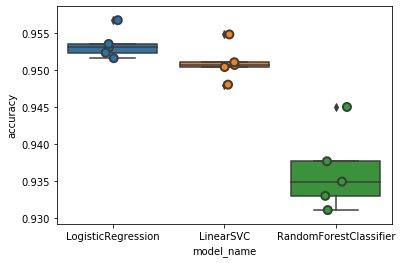

,model_name,fold_idx,accuracy
0,LogisticRegression,0,0.956700
1,LogisticRegression,1,0.953042
2,LogisticRegression,2,0.951580
3,LogisticRegression,3,0.952311
4,LogisticRegression,4,0.953499
5,LinearSVC,0,0.954782
6,LinearSVC,1,0.950667
7,LinearSVC,2,0.948018
8,LinearSVC,3,0.951032
9,LinearSVC,4,0.950393


In [55]:
# Model Training for InfoTheory
model_training(y_train_Info)

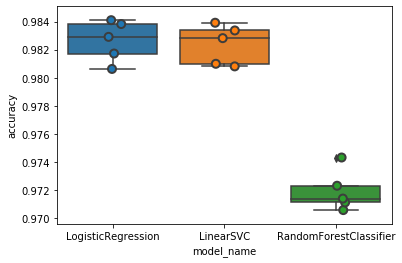

,model_name,fold_idx,accuracy
0,LogisticRegression,0,0.981730
1,LogisticRegression,1,0.980632
2,LogisticRegression,2,0.982916
3,LogisticRegression,3,0.984104
4,LogisticRegression,4,0.983830
5,LinearSVC,0,0.980999
6,LinearSVC,1,0.980815
7,LinearSVC,2,0.982825
8,LinearSVC,3,0.983921
9,LinearSVC,4,0.983373


In [56]:
# Model Training for Comp
model_training(y_train_Comp)

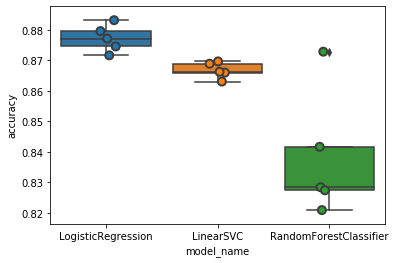

,model_name,fold_idx,accuracy
0,LogisticRegression,0,0.883164
1,LogisticRegression,1,0.871643
2,LogisticRegression,2,0.874566
3,LogisticRegression,3,0.879591
4,LogisticRegression,4,0.877124
5,LinearSVC,0,0.869645
6,LinearSVC,1,0.863055
7,LinearSVC,2,0.865978
8,LinearSVC,3,0.868902
9,LinearSVC,4,0.866253


In [57]:
# Model Training for Math
model_training(y_train_Math)

#### Test the model

In [60]:
testDocs = cleaned_df_test.Abstract.tolist() 
testLabels_Info = cleaned_df_test.InfoTheory.tolist()
testLabels_Comp = cleaned_df_test.CompVis.tolist()
testLabels_Math = cleaned_df_test.Math.tolist()

# Use the same vectorizer to transform the test set
x_test=vectorizer.transform(testDocs)
y_test_Info=np.asarray(testLabels_Info)
y_test_Comp=np.asarray(testLabels_Comp)
y_test_Math=np.asarray(testLabels_Math)

In [62]:
def model_testing(y_test, y_train):
    models = [
        LogisticRegression(max_iter = 10000),
        LinearSVC(dual = False),
        RandomForestClassifier()
        ]

    for clf in models:
        model_name = clf.__class__.__name__
        clf.fit(x_train, y_train)
        print(model_name)
        # Do the prediction
        y_predict =clf.predict(x_test)
        print(confusion_matrix(y_test,y_predict))
        recall=recall_score(y_test,y_predict,average='macro')
        precision=precision_score(y_test,y_predict,average='macro')
        f1score=f1_score(y_test,y_predict,average='macro')
        accuracy=accuracy_score(y_test,y_predict)
        matthews = matthews_corrcoef(y_test,y_predict) 
        print('Accuracy: '+ str(accuracy))
        print('Macro Precision: '+ str(precision))
        print('Macro Recall: '+ str(recall))
        print('Macro F1 score:'+ str(f1score))
        print('MCC:'+ str(matthews))

In [63]:
#Testing for InfoTheory
model_testing(y_test_Info, y_train_Info)

LogisticRegression
[[15779   283]
 [  625  2991]]
Accuracy: 0.9538570992987092
Macro Precision: 0.9377304647450292
Macro Recall: 0.9047689270724174
Macro F1 score:0.9201235419937366
MCC:0.8418543592849207
LinearSVC
[[15704   358]
 [  610  3006]]
Accuracy: 0.9508080089439984
Macro Precision: 0.9280939373942152
Macro Recall: 0.90450833909089
Macro F1 score:0.9157096805939948
MCC:0.8322681481114449
RandomForestClassifier
[[15926   136]
 [ 1111  2505]]
Accuracy: 0.936629738794593
Macro Precision: 0.9416466715414611
Macro Recall: 0.8421436175693082
Macro F1 score:0.8815141790884532
MCC:0.7774486218101865


In [64]:
#Testing for InfoTheory
model_testing(y_test_Comp, y_train_Comp)

LogisticRegression
[[17415   111]
 [  502  1650]]
Accuracy: 0.9688484602093709
Macro Precision: 0.9544747743213811
Macro Recall: 0.8801975885429062
Macro F1 score:0.9130236640671017
MCC:0.8313608440396277
LinearSVC
[[17389   137]
 [  467  1685]]
Accuracy: 0.9693058237625775
Macro Precision: 0.9493271147838642
Macro Recall: 0.8875878036964306
Macro F1 score:0.9154706257680747
MCC:0.8346345537067872
RandomForestClassifier
[[17494    32]
 [ 1347   805]]
Accuracy: 0.9299217400142291
Macro Precision: 0.9451375996462125
Macro Recall: 0.6861223866230395
Macro F1 score:0.7503613468447378
MCC:0.5756737701921258


In [65]:
#Testing for InfoTheory
model_testing(y_test_Math, y_train_Math)

LogisticRegression
[[12633  1115]
 [ 1451  4479]]
Accuracy: 0.8696005691635329
Macro Precision: 0.8488272951798378
Macro Recall: 0.8371046335852133
Macro F1 score:0.842569112797477
MCC:0.6858317505806223
LinearSVC
[[12466  1282]
 [ 1476  4454]]
Accuracy: 0.8598434800284582
Macro Precision: 0.8353160693424662
Macro Recall: 0.8289230970771895
Macro F1 score:0.8319918729917208
MCC:0.6642084011148115
RandomForestClassifier
[[13591   157]
 [ 3088  2842]]
Accuracy: 0.8350950299827218
Macro Precision: 0.8812531111105825
Macro Recall: 0.733919083615903
Macro F1 score:0.7649643720575301
MCC:0.5972683764496475


#### Results of Method

**Since the logistic Regression has better result than others so the confusion matrix below will be taken out from the outcome of that classification algorithm.**

Full confusion matrix for method on InfoTheory:

|              | Pred=True | Pred=False |
| -----------  | ----------- | ----------- |
| **Actual=True**  | 15779       |   283  |
| **Actual=False** |  625     |   2991|

Full confusion matrix for method on CompVis:

|              | Pred=True | Pred=False |
| -----------  | ----------- | ----------- |
| **Actual=True**  | 17415      |  111  |
| **Actual=False** | 502       |   1650 |

Full confusion matrix for method on Math:

|              | Pred=True | Pred=False |
| -----------  | ----------- | ----------- |
| **Actual=True**  | 12633    |  1115  |
| **Actual=False** | 1451     |  4479|

## Part 2: Topic Modelling

General comments and any shared processing here.


In [3]:
from pprint import pprint
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import pandas as pd

### Load data.





In [4]:
# load up the data
import pandas as pd
text_data = []
df = pd.read_csv('Monash_crawled.csv')
docs = df['body'].tolist()
print(len(docs))
print(docs)

366
[' Canberra\n has experienced its worst air quality on record, as bushfire smoke \nbecame trapped by atmospheric conditions and residents were told to stay\n indoors and brace for more smog in the coming days.   The ACTas \nacting chief health officer, Dr Paul Dugdale, said the smoke was the \nworst since the 2003 bushfires and was acertainly the worsta since air \nquality monitoring started in the city 15 years ago.   Air quality \nindex readings in Canberra city were at 3,463 on Wednesday afternoon, \naccording to the ACT Health website. Ratings of more than 200 are \nconsidered hazardous. The suburb of Monash showed levels at 4,650 and \nFlorey was at 3,508.   An ACT health spokesperson said the AQI \nreading for fine particles peaked at 7700 at 1am on Wednesday at the \nMonash monitoring site.   The Canberra-based University of NSW \nclimate scientist Dr Sophie Lewis was out in the city with her \ntwo-year-old daughter and said the conditions were alike nothing I have \nexperie

### Pre-process data

In [5]:
# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for i in range(len(docs)):
    docs[i] = docs[i].lower()
    docs[i] = tokenizer.tokenize(docs[i])

In [6]:
print(len(docs[0]))

620


In [7]:
# Remove numbers, but not words that contain numbers and Remove words that are only 2 characters
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
docs = [[token for token in doc if len(token) > 2] for doc in docs]


In [8]:
print(len(docs[0]))

502


In [9]:
# Lemmatize the documents.
lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
len(docs[0])
print(docs[0])

['canberra', 'ha', 'experienced', 'it', 'worst', 'air', 'quality', 'record', 'bushfire', 'smoke', 'became', 'trapped', 'atmospheric', 'condition', 'and', 'resident', 'were', 'told', 'stay', 'indoors', 'and', 'brace', 'for', 'more', 'smog', 'the', 'coming', 'day', 'the', 'actas', 'acting', 'chief', 'health', 'officer', 'paul', 'dugdale', 'said', 'the', 'smoke', 'wa', 'the', 'worst', 'since', 'the', 'bushfires', 'and', 'wa', 'acertainly', 'the', 'worsta', 'since', 'air', 'quality', 'monitoring', 'started', 'the', 'city', 'year', 'ago', 'air', 'quality', 'index', 'reading', 'canberra', 'city', 'were', 'wednesday', 'afternoon', 'according', 'the', 'act', 'health', 'website', 'rating', 'more', 'than', 'are', 'considered', 'hazardous', 'the', 'suburb', 'monash', 'showed', 'level', 'and', 'florey', 'wa', 'act', 'health', 'spokesperson', 'said', 'the', 'aqi', 'reading', 'for', 'fine', 'particle', 'peaked', '1am', 'wednesday', 'the', 'monash', 'monitoring', 'site', 'the', 'canberra', 'based', '

In [10]:
# Add bigrams to docs (only ones that appear at least 10 times or more).
bigram = Phrases(docs,min_count= 10)
[[docs[i].append(token) for token in bigram[docs[i]] if '_' in token] for i in range(len(docs))]

print(bigram)

Phrases<133382 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>


In [11]:
len(docs[0])

523

In [12]:
print(docs[0])

['canberra', 'ha', 'experienced', 'it', 'worst', 'air', 'quality', 'record', 'bushfire', 'smoke', 'became', 'trapped', 'atmospheric', 'condition', 'and', 'resident', 'were', 'told', 'stay', 'indoors', 'and', 'brace', 'for', 'more', 'smog', 'the', 'coming', 'day', 'the', 'actas', 'acting', 'chief', 'health', 'officer', 'paul', 'dugdale', 'said', 'the', 'smoke', 'wa', 'the', 'worst', 'since', 'the', 'bushfires', 'and', 'wa', 'acertainly', 'the', 'worsta', 'since', 'air', 'quality', 'monitoring', 'started', 'the', 'city', 'year', 'ago', 'air', 'quality', 'index', 'reading', 'canberra', 'city', 'were', 'wednesday', 'afternoon', 'according', 'the', 'act', 'health', 'website', 'rating', 'more', 'than', 'are', 'considered', 'hazardous', 'the', 'suburb', 'monash', 'showed', 'level', 'and', 'florey', 'wa', 'act', 'health', 'spokesperson', 'said', 'the', 'aqi', 'reading', 'for', 'fine', 'particle', 'peaked', '1am', 'wednesday', 'the', 'monash', 'monitoring', 'site', 'the', 'canberra', 'based', '

**Note**: I tried to extract the trigram and add in the docs, however, the extracted words seems not really meaningful. So in this documents, bigrams should be enough.

trigram = Phrases(bigram[docs],min_count=1, delimiter= b' ')

[[docs[i].append(token) for token in trigram[docs[i]] if '_' in token] for i in range(len(docs))]


In [13]:
# Create a dictionary representation of the documents 
dictionary = Dictionary(docs)

#Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5) 
print(dictionary)

Dictionary(1383 unique tokens: ['able', 'above', 'according', 'act', 'activity']...)


In [14]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
print(corpus)

[[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 9), (10, 6), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 3), (23, 5), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 4), (34, 1), (35, 1), (36, 1), (37, 7), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 2), (48, 1), (49, 1), (50, 2), (51, 2), (52, 1), (53, 2), (54, 1), (55, 1), (56, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 2), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 2), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 2), (89, 1), (90, 1), (91, 1), (92, 1), (93, 3), (94, 1), (95, 2), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 6), (110, 1)

In [15]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1383
Number of documents: 366


In [16]:
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

### Transform documents to a vectorized form.

### Train an LDA model.

In [33]:
# Make a index to word dictionary.
temp = dictionary[0]
id2word = dictionary.id2token

# Set training parameters.
chunk_size = 2000
passes = 20
iterations = 400
eval_every = None


In [19]:
#implement the function to calculate the Coherance Scoce for different values of number of topics
def compute_coherence_values_LDA(texts,limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
   
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    LDA_model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(
                corpus = corpus,
                id2word=id2word,
                random_state=100,
                chunksize=chunk_size,
                alpha='auto',
                eta='auto',
                iterations=iterations,
                num_topics=num_topics,
                passes=passes,
                eval_every=None
                )
        LDA_model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return LDA_model_list, coherence_values

In [20]:
LDA_model_list, LDA_coherence_values = compute_coherence_values_LDA(texts=docs, start=2, limit=30, step=6)

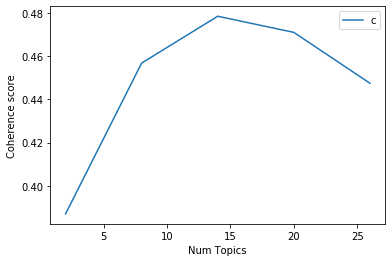

In [21]:
# Show graph
limit=30; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, LDA_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, LDA_coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.387
Num Topics = 8  has Coherence Value of 0.4568
Num Topics = 14  has Coherence Value of 0.4784
Num Topics = 20  has Coherence Value of 0.471
Num Topics = 26  has Coherence Value of 0.4474


**Comment**: It could be seen that when the number of topic equals 14, the Coherence Score reached the peak

In [34]:
# Select the model and print the topics
optimal_Lda_model = LDA_model_list[2]
model_topics = optimal_Lda_model.show_topics(formatted=False)
pprint(optimal_Lda_model.print_topics(num_words=10))

[(0,
  '0.048*"area" + 0.030*"she" + 0.023*"woman" + 0.019*"her" + 0.017*"data" + '
  '0.012*"each" + 0.012*"based" + 0.011*"analysis" + 0.009*"network" + '
  '0.009*"amp"'),
 (1,
  '0.022*"wuhan" + 0.021*"island" + 0.018*"flight" + 0.015*"christmas" + '
  '0.014*"christmas_island" + 0.010*"evacuee" + 0.010*"quarantine" + '
  '0.009*"february_february" + 0.009*"january_january" + 0.009*"qantas"'),
 (2,
  '0.016*"fire" + 0.016*"smoke" + 0.011*"air" + 0.010*"school" + '
  '0.009*"melbourne" + 0.008*"state" + 0.008*"open" + 0.008*"home" + '
  '0.007*"quality" + 0.005*"air_quality"'),
 (3,
  '0.032*"ship" + 0.024*"cruise" + 0.019*"passenger" + 0.018*"princess" + '
  '0.016*"cruise_ship" + 0.016*"diamond_princess" + 0.016*"diamond" + '
  '0.014*"japan" + 0.012*"tested" + 0.010*"board"'),
 (4,
  '0.016*"flight" + 0.012*"wuhan" + 0.011*"confirmed" + 0.010*"melbourne" + '
  '0.009*"she" + 0.009*"sydney" + 0.009*"chinese" + 0.007*"infected" + '
  '0.007*"hospital" + 0.006*"woman"'),
 (5,
  '0.0

In [35]:
lda_display = pyLDAvis.gensim.prepare(optimal_Lda_model, corpus, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

**Comment**: Let try another version of LDA to have a better look on the resultm

#### Train LDAmallet 

In [26]:
import os

os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})

mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet'

#ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=dictionary)


**Note**:

    +/Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
    +/Create a new folder ('new_mallet') in c:/ drive and unzip the mallet there and run the code 

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [29]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)

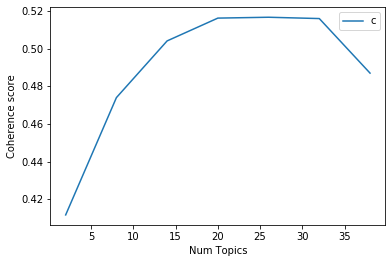

In [30]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [31]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4116
Num Topics = 8  has Coherence Value of 0.474
Num Topics = 14  has Coherence Value of 0.5041
Num Topics = 20  has Coherence Value of 0.5163
Num Topics = 26  has Coherence Value of 0.5167
Num Topics = 32  has Coherence Value of 0.516
Num Topics = 38  has Coherence Value of 0.487


**Comment**: It seems that the model with number of topic equals 26 had the highest Coherance Value. By using the LDAmallet, the Cohesense score had increase a bit form (0.47 to 0.52)

In [39]:
# Select the model and print the topics
optimal_LdaMallet_model = model_list[4]
model_topics = optimal_LdaMallet_model.show_topics(formatted=False)
pprint(optimal_LdaMallet_model.print_topics(num_words=10))

[(23,
  '0.053*"food" + 0.045*"hand" + 0.035*"supply" + 0.034*"store" + '
  '0.030*"customer" + 0.028*"stock" + 0.026*"daily" + 0.023*"paper" + '
  '0.020*"shelf" + 0.020*"toilet"'),
 (19,
  '0.069*"study" + 0.050*"patient" + 0.047*"level" + 0.031*"normal" + '
  '0.031*"group" + 0.029*"mass" + 0.026*"test" + 0.024*"higher" + '
  '0.022*"found" + 0.019*"compared"'),
 (14,
  '0.071*"fire" + 0.044*"climate" + 0.042*"smoke" + 0.036*"change" + '
  '0.032*"bushfires" + 0.026*"climate_change" + 0.024*"air" + 0.022*"bushfire" '
  '+ 0.020*"quality" + 0.018*"condition"'),
 (15,
  '0.069*"family" + 0.053*"city" + 0.044*"child" + 0.027*"home" + '
  '0.025*"deadly" + 0.024*"sunday" + 0.021*"trapped" + 0.020*"left" + '
  '0.018*"stay" + 0.018*"month"'),
 (2,
  '0.111*"area" + 0.040*"data" + 0.033*"based" + 0.023*"image" + '
  '0.023*"result" + 0.022*"human" + 0.020*"amp" + 0.018*"analysis" + '
  '0.017*"site" + 0.017*"network"'),
 (25,
  '0.079*"flight" + 0.057*"island" + 0.048*"wuhan" + 0.039*"chr